In [8]:
!pip install livelossplot

In [9]:
!pip install pycm

In [10]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from pycm import *
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


# PSEUDO CODE FOR FFN IMPLEMENTATION

In [58]:
# ### Step 1 :  We use the nn.Module class to define our network:
# class DummyNetwork(nn.Module):
#     def __init__(self):
#         super(DummyNetwork, self).__init__()
#         # define your layers and activations
        
#     def forward(self, x):
#         # define your network forward pass
#         # return output of the network
        
# ### Step 2 : Training loop structure
# model = DummyNetwork()                                    # get an instance of your network 
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # define an optimiser (SGC, Adam, etc) and tell it what it is optimising
# criterion = torch.nn.MSELoss()                            # define your loss function
# model.train()                                             # tell the model we are going to train
#     for X, y in data_loader:                              # iterate over epochs
#         optimizer.zero_grad()                             # reset gradients
#         output = model(X)          # forward propagtion through the model
#         loss = criterion(y, output)    # compute loss
#         loss.backward()            # backpropagate
#         optimizer.step()           # update model parameters using the gradients


# Training a deep neural network on MNIST using Pytorch

- Design a fully connected feed forward neural network for MNIST
- Create a validation split and normalise it (standardise it really)
- Perform a manual grid search on the momentum parameters
- Combine validation and training set once we have optimal momentum parameters and train the model again
- Run the test dataset and report accuracy
- Generate some of the plots we saw in the theory lectures to analyse performance

In [59]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

In [60]:
# Instantiate and create a ```StratifiedShuffleSplit``` generator using sklearn

# 1. Create a sklearn.model_selection.StratifiedShuffleSplit object with 1-split and a test-size of 10%.
# 2. Get the training and validation indices from the shuffel-split

shuffler = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=42).split(mnist_train.data, mnist_train.targets) # create a shuffler
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0] # extract indices
# print('indices type: ', type(indices))
print('indices: ', indices)
print('mnist_train type: ', type(mnist_train))
print('mnist_train.data type: ', type(mnist_train.data))
print('mnist_train.targets type: ', type(mnist_train.targets))
print('mnist_train.targets size: ', mnist_train.targets.size())
print('mnist_train targets: ', mnist_train.targets)
print('pixel value of one mnist_train image: ', mnist_train.data[0][14][14].item())

indices:  (array([50700, 15345,  2527, ...,  4176, 14834, 39484], dtype=int64), array([58886, 22875, 48551, ..., 13829, 40340, 38131], dtype=int64))
mnist_train type:  <class 'torchvision.datasets.mnist.MNIST'>
mnist_train.data type:  <class 'torch.Tensor'>
mnist_train.targets type:  <class 'torch.Tensor'>
mnist_train.targets size:  torch.Size([60000])
mnist_train targets:  tensor([5, 0, 4,  ..., 5, 6, 8])
pixel value of one mnist_train image:  240


In [61]:
indices

(array([50700, 15345,  2527, ...,  4176, 14834, 39484], dtype=int64),
 array([58886, 22875, 48551, ..., 13829, 40340, 38131], dtype=int64))

## Normalization

In [62]:
# Apply normalization
def apply_normalization(X):
  X /= 255. ## normalize pixel values to the range 0 to 1. Pixel values are often unsigned integers in the range between 0 and 255.
  X -= 0.1307 ## mean of the pixel values in this data set is 0.1307
  X /= 0.3081 ## variance of the pixel values in this dataset is 0.3081
  return X

In [63]:
X_train, y_train = apply_normalization(mnist_train.data[indices[0]].float()), mnist_train.targets[indices[0]] # index is 0 because that's how we defined the indices above
X_val, y_val = apply_normalization(mnist_train.data[indices[1]].float()), mnist_train.targets[indices[1]]     # index is 1 because that's how we defined the indices above
X_test, y_test =  apply_normalization(mnist_test.data.float()), mnist_test.targets                            # test dataset

## Efficient DataLoading

In [64]:
mnist_train = TensorDataset(X_train, y_train.long())    # PyTorch wants longs for categorical data
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

0.00011969513434451073 1.000293493270874


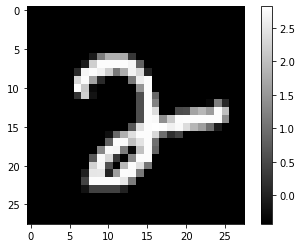

In [18]:
# Check the mean and standard deviation ie check if the data is properly normalized

plt.imshow(X_train[0], cmap="gray") # plot one element of my training set
plt.colorbar()
print(X_train.mean().item(), X_train.std().item()) # plot one element of my training set

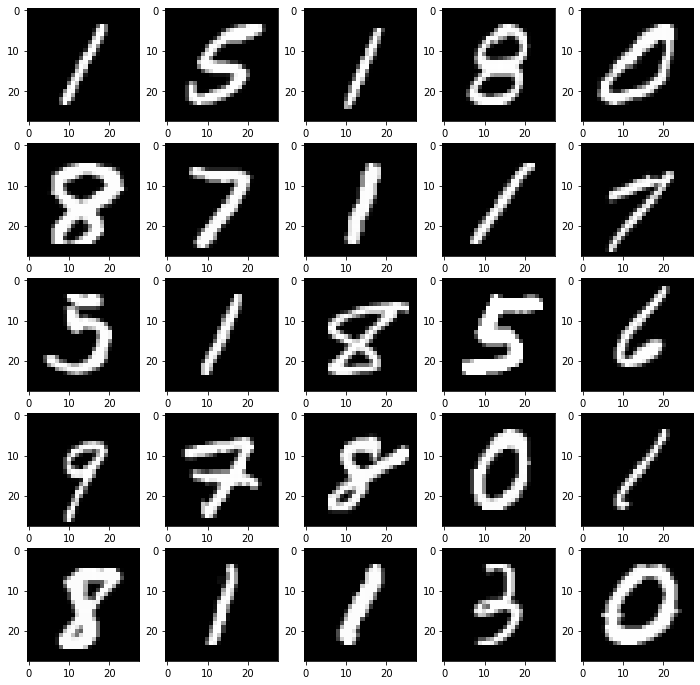

In [19]:
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i], cmap="gray")
plt.show()

## Create a SimpleNet as a ```nn.Module```
Create a simple feed-forward neural network with the following architecture:
- Input Layer: 28*28 neurons
- Hidden Layer: 25 neurons
- Output Layer: 10 neurons
- Hidden Layer Activation: ReLU
- Output Layer Activation: None

In [20]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear_1 = nn.Linear(28*28, 25) # use nn.Linear and nn.Relu to define your layers and activations
        self.linear_2 = nn.Linear(25, 10)    
        self.activation = nn.ReLU()          
        
    def forward(self, x):
        z1 = self.linear_1(x)               # code your forward pass using the layers and activations above
        a1 = self.activation(z1)
        z2 = self.linear_2(a1)
        return z2                          # return z2 (not a2, we will see this later)
        # return x
        # return z1
        # return a1

In [34]:
# Check the sizes of the diffrerent layers
set_seed(42) 

model = SimpleNet()

X_ = X_train[0].view(-1,28*28)

y_ = model(X_) 

# input layer
print( "\nInput layer :  ")
print(X_.shape,X_.max())
# output layer
print( "\nOutput layer :  ")
print(y_.shape,y_.max())#.item())

# print the model
print( "\nModel :  ")
print(y_train.shape)


Input layer :  
torch.Size([1, 784]) tensor(2.8215)

Output layer :  
torch.Size([1, 10]) tensor(0.3337, grad_fn=<MaxBackward1>)

Model :  
torch.Size([54000])


## Sanity Checks - Single Forward Pass

In [47]:
set_seed(42) 

model = SimpleNet().to(device) # .to(device) loads the model on the device, i.e GPUs in this example
criterion = nn.CrossEntropyLoss() # change to NLLLoss if you want to keep the softmax in the module (network)

X = X_train[0].view(-1, 28*28).to(device)  # get 1 sample only. Also .view(-1,28*28) reshapes the tensor to get it ready for the first fully connected layer. 
# the dimension of -1 implies that the actual value for this dimension will be inferred so that the number of elements in the view matches the original number of elements.

y = torch.zeros((1)).to(device).long().to(device) # loads the tensor to the current device in use, i.e the GPUs
a2 = model(X_) # a2 = z2 in this case since SimpleNet is returning z2

loss = criterion(a2, y_) # the loss criterion CrossEntropyLoss(), combines nn.LogSoftMax and nn.NLLLoss so it is essentially computing the loss between the non_linear transform of z2 and the label y_

y_pred = F.log_softmax(a2, dim=1).max(1)[1] # gives the predicted value as the maximum probability value index based on the log_softmax operation on a2

print(F.log_softmax(a2, dim=1))
print('prediction:                                 ', y_pred.item())
print('true value (we force it to be zero above!): ', y_.item())

tensor([[-2.3002, -2.2015, -2.3132, -2.7334, -2.3650, -2.3482, -2.2407, -2.1243,
         -2.6117, -1.9923]], grad_fn=<LogSoftmaxBackward0>)
prediction:                                  9
true value (we force it to be zero above!):  0


# Train Function

The function should perform the following tasks:
1. Set the model into training mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
4. Zero all the gradients
5. Perform the forward-pass
6. Compute the loss
7. Perform the backward-pass
8. Keep a running measure of training loss and accuracy
9. Perform a step of gradient-descent
10. Once done with all batches, return average training loss and accuracy

In [48]:
def train(model, optimizer, criterion, data_loader):
    
    # the model is in the training mode so the parameters(weights)to be optimised will be updated
    model.train()   
    
    # initialise loss and accuracy to 0 for training
    train_loss, train_accuracy = 0, 0     
    
    # iterate over the mini-batches defined in the data loader
    for X, y in data_loader:  
        
        # send data to the device (GPU in our case)
        X, y = X.to(device), y.to(device) 
        
        # resetting optimiser info
        optimizer.zero_grad()  
        
        # forward pass
        a2 = model(X.view(-1, 28*28))     
        # compute loss
        loss = criterion(a2, y)           
        # backpropagation to calculate the gradients
        loss.backward()       
        
        # add it up for different mini-batches and undo loss normalisation
        train_loss += loss*X.size(0)  
        
        # get predictions
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  
        # compute accuracy
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) 
        # perform a step of gradient descent
        optimizer.step() 
        
    # here we can average over the whole dataset    
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  

## Validate Function

The function should perform the following tasks:
1. Set the model into evaluation mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
5. Perform the forward-pass
6. Compute the loss
8. Keep a running measure of validation loss and accuracy
10. Once done with all batches, return average validation loss and accuracy


Note : 
`torch.no_grad()`: tells PyTorch that I am not interested in computing gradients to reduce computations and memory.
`model.eval()`: tells PyTorch I am going to use the trained model now, so any funny business happening with dropout or batch normalisation should be treated differently than in training.

In [49]:
def validate(model, criterion, data_loader):      # does not need optimiser
    
    # model is set to evaluation mode so no dropout and such
    model.eval()                                  
    # initialise loss and accuracy to 0 for training
    validation_loss, validation_accuracy = 0., 0. 
    
    # iterate over the mini-batches defined in the data loader
    for X, y in data_loader:  
        # deactivates autograd engine
        with torch.no_grad():
            # send data to the device (GPU in our case)
            X, y = X.to(device), y.to(device) 
            
            # forward pass
            a2 = model(X.view(-1, 28*28))  
            # define the loss criterion
            loss = criterion(a2, y)
            
            # add it up for different mini-batches and undo loss normalisation
            validation_loss += loss*X.size(0)  
            
            # get predictions
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  
            
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

## Set the Hyperparameters

- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training, but affects validation times): 1000
- Shuffle the training set every epoch: Yes

In [50]:
# Set the hypweparameters
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

## Instantiate our model, optimizer and loss function

In [65]:
set_seed(seed)

# Instantiate the model
model = SimpleNet().to(device)

# Select the optimizer function
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()


## Create DataLoaders for Training, Validation, Testing

In [66]:
train_loader = DataLoader(mnist_train, batch_size= batch_size, shuffle=True, num_workers=0)
# Note : Here num_workers = 0 runs all the data through one thread
# If num_workers=2 for example, 2 other workers will put data into the RAM instead of the main process
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)

test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

## Perform the training of the network and validation

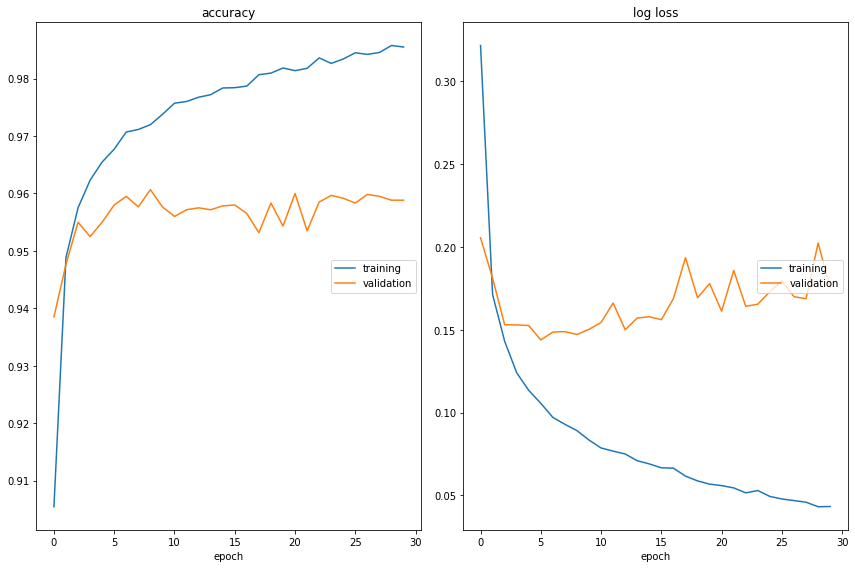

accuracy
	training         	 (min:    0.905, max:    0.986, cur:    0.986)
	validation       	 (min:    0.939, max:    0.961, cur:    0.959)
log loss
	training         	 (min:    0.043, max:    0.322, cur:    0.043)
	validation       	 (min:    0.144, max:    0.206, cur:    0.175)
0.17549382150173187


In [67]:
set_seed(seed)

# Plot lossed plots the evolution of loss and accuracy
liveloss = PlotLosses()

for epoch in range(30):
    
    # create a dictonary for logs of the losses
    logs = {}
    
    # Call the train function and obtain the training loss and accuracy
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    # Call the validate function and obtain the validation loss and accuracy
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

## Running a grid-search

In [68]:
def train_model(momentum):          # define function train_momentum which accepts one argument (momentum)
  set_seed(seed)                    # set seed
  model = SimpleNet().to(device)    # instantiate model and send it to the GPU
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # define an optimiser
  criterion = nn.CrossEntropyLoss() # define the loss function
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)               # train_loader
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # validation_loader
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)           # test_loader
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['log loss'] = train_loss.item()
      logs['accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_log loss'] = validation_loss.item()
      logs['val_accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return True

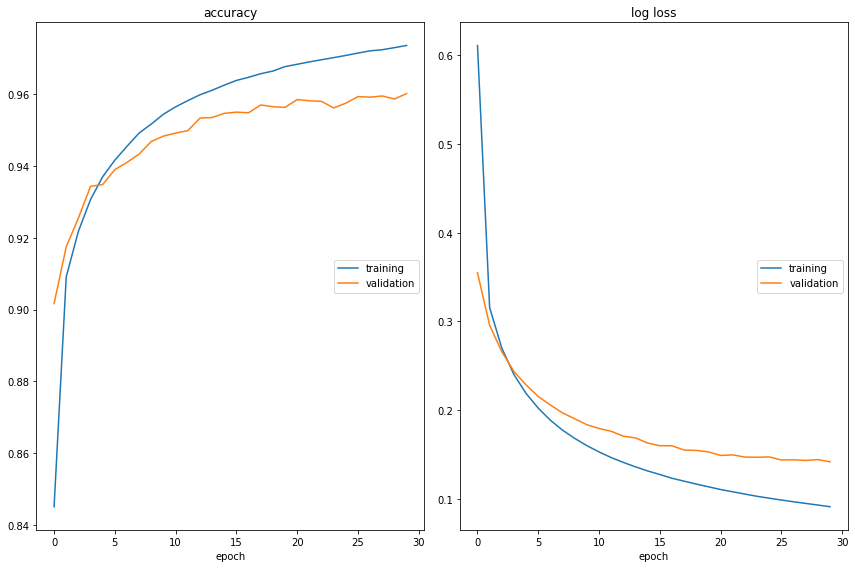

accuracy
	training         	 (min:    0.845, max:    0.974, cur:    0.974)
	validation       	 (min:    0.902, max:    0.960, cur:    0.960)
log loss
	training         	 (min:    0.091, max:    0.611, cur:    0.091)
	validation       	 (min:    0.142, max:    0.355, cur:    0.142)


True

In [69]:
train_model(0.1)

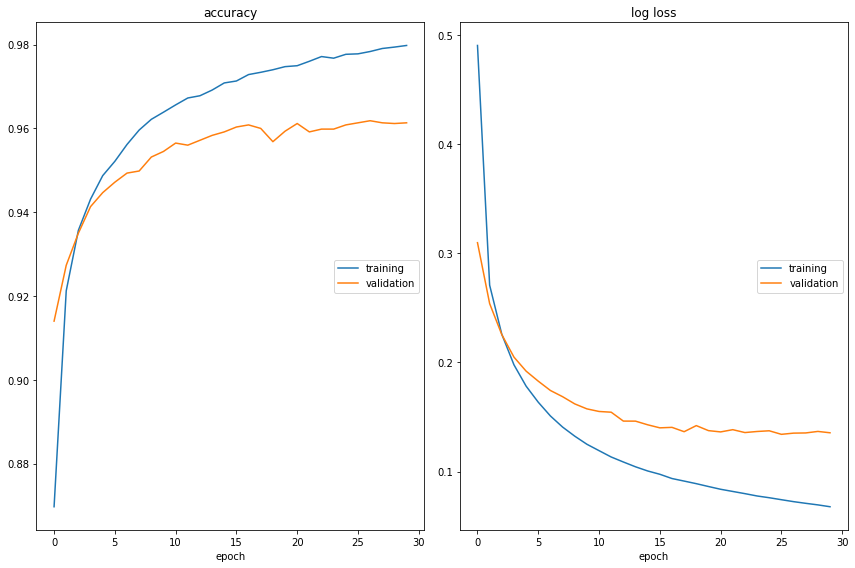

accuracy
	training         	 (min:    0.870, max:    0.980, cur:    0.980)
	validation       	 (min:    0.914, max:    0.962, cur:    0.961)
log loss
	training         	 (min:    0.068, max:    0.490, cur:    0.068)
	validation       	 (min:    0.134, max:    0.310, cur:    0.136)


True

In [70]:
train_model(0.5)

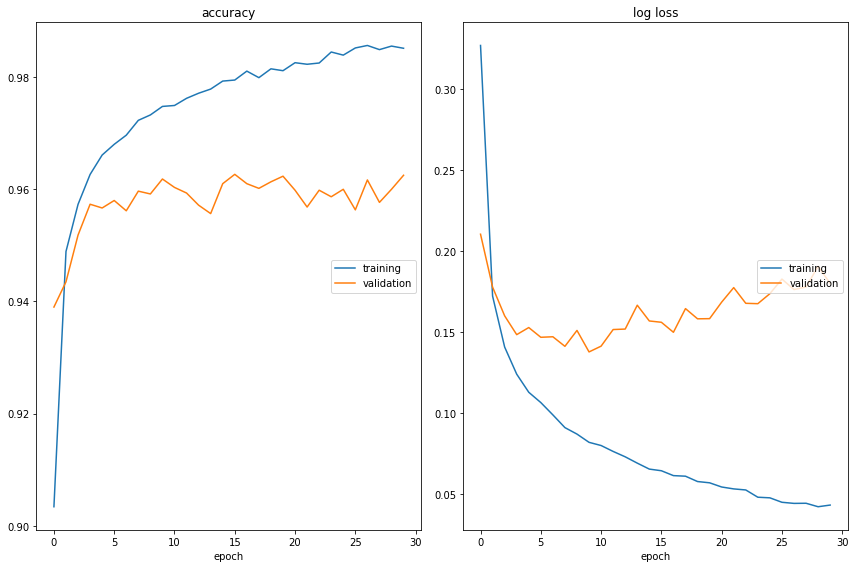

accuracy
	training         	 (min:    0.903, max:    0.986, cur:    0.985)
	validation       	 (min:    0.939, max:    0.963, cur:    0.963)
log loss
	training         	 (min:    0.042, max:    0.327, cur:    0.043)
	validation       	 (min:    0.138, max:    0.210, cur:    0.180)


True

In [71]:
train_model(0.9)

# Implement an evaluate method

In [72]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device) # data and labels to device
            a2 = model(X.view(-1, 28*28))     # forward pass and reshape tensor and get it ready to the fully connected layer
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # calculate prediction
            ys.append(y.cpu().numpy())        # save predictions
            y_preds.append(y_pred.cpu().numpy()) # save predictions
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) ## concatenate the labels of each batch into a single list

y_pred, y_gt = evaluate(model, validation_loader)
print(y_pred, y_gt)

[1 9 3 ... 3 0 4] [1 9 3 ... 5 0 4]


# Printing the confusion matrix

In [73]:
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) ## Create the confusion matrix from Data. ConfusionMatrix is a class derived from the pycm library
print(cm)
## the rows of the confusion matrix give the number of the instances in the actual class that were wrongly predicted.

Predict   0         1         2         3         4         5         6         7         8         9         
Actual
0         584       1         2         0         0         1         0         0         2         2         

1         0         662       4         1         0         0         1         1         4         1         

2         2         5         575       0         3         0         4         4         3         0         

3         1         0         9         588       0         6         0         1         7         1         

4         2         1         2         1         558       0         1         5         3         11        

5         3         1         0         8         3         519       3         1         3         1         

6         15        0         1         0         7         3         565       0         1         0         

7         4         1         4         2         4         1         0         605       1       

C:\Users\Niranjana\AppData\Local\Programs\Python\Python310\lib\site-packages\pycm\pycm_obj.py:206: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


<AxesSubplot:>

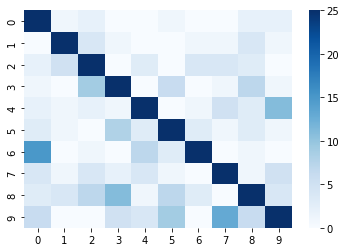

In [74]:
import seaborn as sns

def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

rcm = to_raw_matrix(cm) #store the confusion matrix values

sns.heatmap(rcm, cmap="Blues", vmin=0, vmax=25)

# Train the model on the full dataset and evaluate on the test set

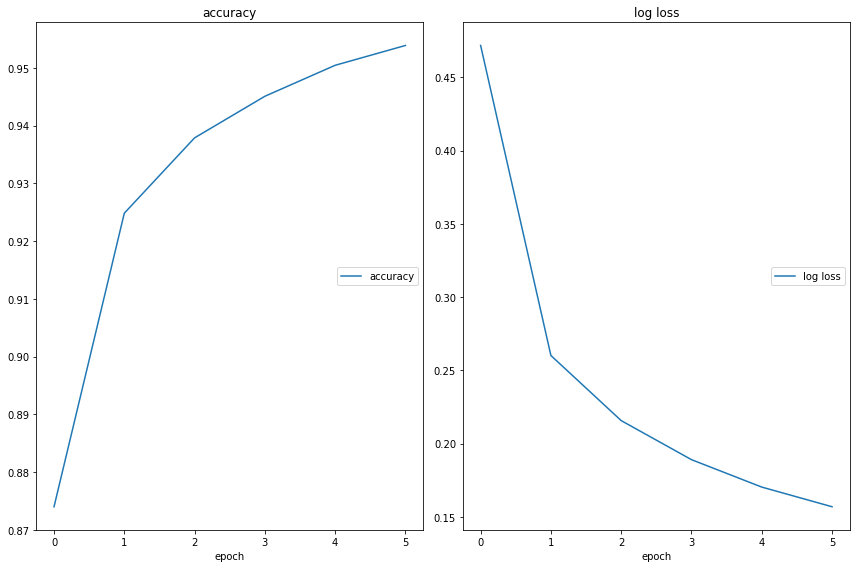

accuracy
	accuracy         	 (min:    0.874, max:    0.954, cur:    0.954)
log loss
	log loss         	 (min:    0.157, max:    0.472, cur:    0.157)


In [ ]:
mnist_train = MNIST("./", download=True, train=True)

X_train, y_train = apply_normalization(mnist_train.train_data.float()), mnist_train.train_labels
mnist_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)  # now we define 4 workers to load the mini-batches

set_seed(seed) # set seed 
model = SimpleNet().to(device) # take model to device
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5) # define optimiser
criterion = nn.CrossEntropyLoss() # define loss

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {} # dictionary 
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader) # train the model

    logs['log loss'] = train_loss.item() # store loss
    logs['accuracy'] = train_accuracy.item() # store accuracy

    # test_loss, test_accuracy = validate(model, criterion, test_loader)
    # logs['val_' + 'log loss'] = test_loss.item()
    # logs['val_' + 'accuracy'] = test_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)    # first time we use the test dataset!
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")